<center> <h1> Diagnose Latent Cytomegalovirus Using CyTOF Data and Deep Learning <h1> </center>

<center>Zicheng Hu, Ph.D.</center>
<center>Research Scientist</center>
<center>ImmPort Team</center>
<center>The Unversity of California, San Francisco</center>

![alt text](Data/header.png)

In [51]:
##### Step 1: import functions #####
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Activation, Conv2D, AveragePooling2D, Input, Softmax
from tensorflow.keras.models import load_model, Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model
import pickle
import pandas as pd
import numpy as np
from numpy.random import seed; seed(111)
import random
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.random import set_seed; set_seed(111)
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import normalize
from six import StringIO  
from sklearn.tree import export_graphviz, DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from scipy.stats import ttest_ind
from IPython.display import Image  
import pydotplus
import time

In [2]:
gpus = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

In [11]:
phenotype = 'Subject Age'

In [12]:
##### Step 2: load data #####

tutorial_files = ! ls Data
if "allData.obj" not in tutorial_files:
    print("Downloading Data:")
    ! wget https://ucsf.box.com/shared/static/tn8m9hco3f3gugn7z394yzimvtfdg129.obj -O ./Data/allData.obj
        
#load data
with open("FCS_to_Array/agingData.obj", "rb") as f:
    allData = pickle.load(f)
metaData = allData["samples"]
cytoData = allData['expr_list']
markerNames = allData["marker_names"]

print("Dimensions of cytoData: ",cytoData.shape,"\n")
print("Names of the makers: \n",markerNames.values)

Dimensions of cytoData:  (753, 20000, 13, 1) 

Names of the makers: 
 ['FSC-A' 'FSC-H' 'FSC-W' 'SSC-A' 'SSC-H' 'SSC-W' 'PSTAT1' 'PSTAT5' 'CD66B'
 'CD33' 'CD3/CD14' 'PSTAT3' 'CD4/CD19']


In [62]:
##### Step 3: split train, validation and test######
y = metaData[phenotype].values
age_range = max(y) - min(y)
y = normalize([y])[0]
# y = np.array([phenos.index(_) for _ in metaData[phenotype].values])
# y = phenos.reshape(list(phenos.shape)+[1])
x = cytoData
# pheno_map = dict(enumerate(phenos))

x_train, x_valid, y_train, y_valid = train_test_split(x, y)
# train_id = (metaData.study_accession.isin(["SDY515","SDY519"])==False)
# valid_id = metaData.study_accession=="SDY515"
# test_id = metaData.study_accession =="SDY519"

# x_train = x[train_id]; y_train = y[train_id]
# x_valid = x[valid_id]; y_valid = y[valid_id]
# x_test = x[test_id]; y_test = y[test_id]

In [54]:
# list(metaData[phenotype].values) == [pheno_map[_[0]] for _ in y]

In [55]:
# ##### Step 4: define model #####

# # input
# model_input = Input(shape=x_train[0].shape)

# # first convolution layer
# model_output = Conv2D(3, kernel_size=(1, x_train.shape[2]),
#                  activation=None)(model_input)
# model_output = BatchNormalization()(model_output)
# model_output = Activation("relu")(model_output)

# # sceond convolution layer
# model_output = Conv2D(3, (1, 1), activation=None)(model_output)
# model_output = BatchNormalization()(model_output)
# model_output = Activation("relu")(model_output)

# # pooling layer
# model_output = AveragePooling2D(pool_size=(x_train.shape[1], 1))(model_output)
# model_output = Flatten()(model_output)

# # Dense layer
# model_output = Dense(3, activation=None)(model_output)
# model_output = BatchNormalization()(model_output)
# model_output = Activation("relu")(model_output)

# # output layer
# model_output = Dense(1, activation=None)(model_output)
# model_output = BatchNormalization()(model_output)
# model_output = Activation("sigmoid")(model_output)

# ##### Step 5: Fit model #####

# # specify input and output
# model = Model(inputs=[model_input],
#               outputs=model_output)

# # define loss function and optimizer
# model.compile(loss='binary_crossentropy',
#               optimizer=Adam(lr=0.0001),
#               metrics=['accuracy'])

# model.summary()

In [76]:
aging_model = Sequential([
    Input(shape=x[0].shape),
    Conv2D(12, kernel_size = (1, x.shape[2]), activation=None),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(12, kernel_size = (1,1), activation=None),
    BatchNormalization(),
    Activation('relu'),
    AveragePooling2D(pool_size = (x.shape[1], 1)),
    Flatten(),
    Dense(12, activation=None),
    BatchNormalization(),
    Activation('relu'),
    Dense(1, activation=None),
#     BatchNormalization(),
#     Activation('sigmoid'),
])
aging_model.compile(loss='mean_absolute_error',
              optimizer='adam',
              metrics=['mean_absolute_error'])
aging_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 20000, 1, 12)      168       
_________________________________________________________________
batch_normalization_21 (Batc (None, 20000, 1, 12)      48        
_________________________________________________________________
activation_19 (Activation)   (None, 20000, 1, 12)      0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 20000, 1, 12)      156       
_________________________________________________________________
batch_normalization_22 (Batc (None, 20000, 1, 12)      48        
_________________________________________________________________
activation_20 (Activation)   (None, 20000, 1, 12)      0         
_________________________________________________________________
average_pooling2d_6 (Average (None, 1, 1, 12)         

In [77]:
model = aging_model

# save the best performing model
checkpointer = ModelCheckpoint(filepath='Result/saved_weights.hdf5', 
                               monitor='val_loss', verbose=0, 
                               save_best_only=True)

st = time.time()
# model training
model.fit([x_train], y_train,
          batch_size=60,
          epochs=250, 
          verbose=1,
          callbacks=[checkpointer],
          validation_data=([x_valid], y_valid))
rt = time.time()-st

Epoch 1/250
10/10 [==============================] - 2s 105ms/step - loss: 0.5238 - mean_absolute_error: 0.5238 - val_loss: 0.7182 - val_mean_absolute_error: 0.7182
Epoch 2/250
10/10 [==============================] - 1s 60ms/step - loss: 0.3757 - mean_absolute_error: 0.3757 - val_loss: 0.5800 - val_mean_absolute_error: 0.5800
Epoch 3/250
10/10 [==============================] - 1s 60ms/step - loss: 0.2972 - mean_absolute_error: 0.2972 - val_loss: 0.5016 - val_mean_absolute_error: 0.5016
Epoch 4/250
10/10 [==============================] - 1s 59ms/step - loss: 0.2127 - mean_absolute_error: 0.2127 - val_loss: 0.3669 - val_mean_absolute_error: 0.3669
Epoch 5/250
10/10 [==============================] - 1s 59ms/step - loss: 0.1613 - mean_absolute_error: 0.1613 - val_loss: 0.2774 - val_mean_absolute_error: 0.2774
Epoch 6/250
10/10 [==============================] - 1s 59ms/step - loss: 0.1477 - mean_absolute_error: 0.1477 - val_loss: 0.2796 - val_mean_absolute_error: 0.2796
Epoch 7/250
10/

In [78]:
rt

149.14373755455017

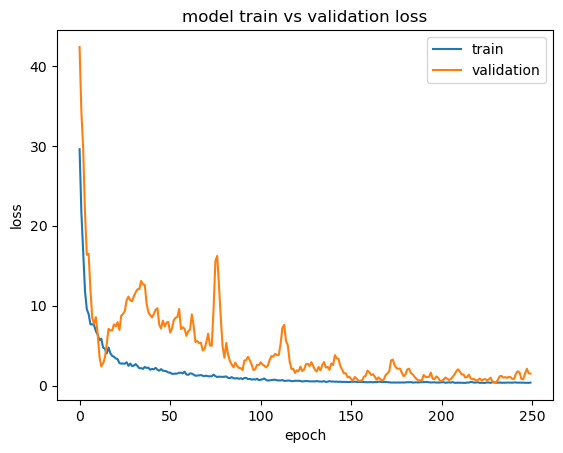

In [79]:
##### Step 6: plot train and validation loss #####
plt.plot(age_range*pd.Series(model.history.history['mean_absolute_error']))
plt.plot(age_range*pd.Series(model.history.history['val_mean_absolute_error']))
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [82]:
#### Step 7: test the final model #####

# load final model
# final_model = load_model('Data/Final_weights.hdf5')
final_model = model
x_test = x_valid
y_test = y_valid

# generate ROC and AUC
y_scores = final_model.predict([x_test])
y_scores = age_range * pd.Series(y_scores.reshape(y_scores.shape[0]))
y_scores.describe()

count    189.000000
mean       1.305863
std        1.883806
min       -3.908248
25%        0.487284
50%        1.474080
75%        2.880858
max        4.509381
dtype: float64